# 1) Introduction: Computational Geometry and scipy.spatial

In [49]:
import scipy
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
scipy.__version__

'0.19.0'

# 2) Distances between arrays of points

## 2.1) scipy.spatial.distance_matrix

### 2.1.1) Euclidean (L2 norm)

There are many cases where it is desirable to calculate the distances between all possible pairs of points from two data sets. Consider a self-driving vehicle that is programmed to avoid animals that enter a roadway. It may have a set of coordinates that represent the vehicle proper relative to some kind of camera / detector, and another set of coordinates that represent the apparent obstruction (animal on the road).

For simplicity, lets define the two sets of coordinates randomly:

In [8]:
vehicle_coords = np.random.random((50,3))
animal_coords = np.random.random((600,3))

In order to calculate the amount of time that the vehicle has to make a course adjustment, it would be sensible to first calculate the closest distance between a point on the vehicle and a point on the animal. Lets try this by calculating all possible distances between the objects and finding the minimum of that distance matrix.

In [11]:
from scipy.spatial import distance_matrix
all_distances = distance_matrix(vehicle_coords, animal_coords)
all_distances.shape

(50, 600)

Each row of the distance matrix represents a point on the vehicle, and each column (value in a given row) is the distance between that point on the vehicle and one of the points on the animal (ordered by index).

In [13]:
closest_distance = all_distances.min()
closest_distance

0.028003950663311409

### 2.1.2) Rectilinear (L1 norm)

Consider another situation, where a self-driving vehicle is aware (i.e., via real-time 'traffic' reporting) of an animal obstructing a roadway, even though the vehicle does not have line of sight to the animal obstacle. The animal is a few city blocks away, but the vehicle would still benefit from a distance & time estimate so that appropriate adjustments may be made. 

In this case, the straight-line Euclidean distance would not represent the shortest distance the vehicle would travel in practice--instead, we need to consider the so-called L1 norm / taxicab geometry/ Manhattan distance, etc. 

In [16]:
taxicab_distances = distance_matrix(vehicle_coords, animal_coords, p=1)
taxicab_distances.shape

(50, 600)

In [17]:
closest_taxicab_distance = taxicab_distances.min()
closest_taxicab_distance

0.039965928608402312

## 2.2) scipy.spatial.distance.cdist

### 2.2.1) Faster than distance_matrix for Euclidean norm

In [18]:
%timeit distance_matrix(vehicle_coords, animal_coords)

1000 loops, best of 3: 1.64 ms per loop


In [19]:
from scipy.spatial.distance import cdist

In [20]:
%timeit cdist(vehicle_coords, animal_coords)

1000 loops, best of 3: 358 µs per loop


In [28]:
# confirm same value for p=2 norm
distance_matrix(vehicle_coords, animal_coords, p=2).min() == cdist(vehicle_coords, animal_coords, metric='euclidean').min()

True

### 2.2.2) Faster than distance_matrix for L1 norm

In [29]:
%timeit distance_matrix(vehicle_coords, animal_coords, p=1)

1000 loops, best of 3: 1.4 ms per loop


Slower with minkowski metric specification though!

In [33]:
%timeit cdist(vehicle_coords, animal_coords, metric='minkowski', p=1)

100 loops, best of 3: 5.23 ms per loop


Use cityblock metric instead of p=1 minkowski

In [34]:
# time equivalent calculation using alternative calling convention
%timeit cdist(vehicle_coords, animal_coords, metric='cityblock')

10000 loops, best of 3: 166 µs per loop


Make sure the two different rectilinear calling conventions produce the same value

In [36]:
cdist(vehicle_coords, animal_coords, metric='minkowski', p=1).min() == cdist(vehicle_coords, animal_coords, metric='cityblock').min()

True

And likewise for cdist vs. distance_matrix for rectilinear distance

In [31]:
# confirm same value for p=1 norm
distance_matrix(vehicle_coords, animal_coords, p=1).min() == cdist(vehicle_coords, animal_coords, metric='minkowski', p=1).min()

True

### 2.2.3) Using cdist for Mahalanobis distance -- clustering and outlier detection

Apart from the enhanced performance (at least for the data shapes tested above) of `cdist` over `distance_matrix`, `cdist` also has access to a wide variety of distance metrics with a plethora of possible applications.

Consider the following ellipsoidal and circular data sets:

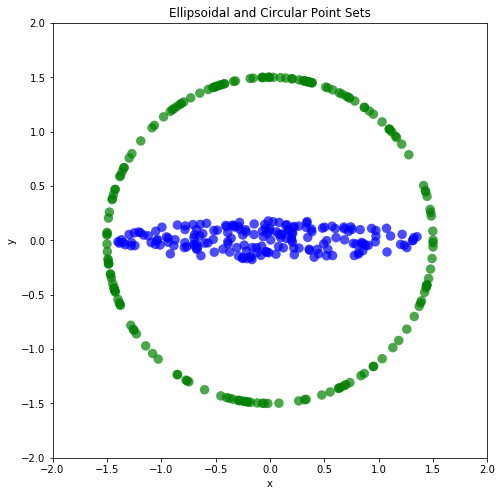

In [92]:
# ellipsoidal point set generation: http://stackoverflow.com/a/5529199/2942522
np.random.seed(255792)
width = 2.82
height = 0.36
phi = np.random.random((180)) * 2 * math.pi 
rho = np.random.random((180))
x_ellipse = np.sqrt(rho) * np.cos(phi)
y_ellipse = np.sqrt(rho) * np.sin(phi)
x_ellipse *= width / 2.0
y_ellipse *= height / 2.0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_ellipse, y_ellipse, c='blue', alpha=0.7, edgecolor='none', s=90)
ax.set_title('Ellipsoidal and Circular Point Sets')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
circle_radius = 1.5
x_circle = np.cos(phi) * circle_radius
y_circle = np.sin(phi) * circle_radius
ax.scatter(x_circle, y_circle, c='green', alpha=0.7, edgecolor='none', s=90)

fig.set_size_inches(8,8)

The Mahalanobis distance for each circular point (relative to the elliptical point set) will account for the "shape" of the ellipse and not just the mean of the elliptical points.



In [108]:
np.dstack((x_ellipse, y_ellipse))[0].shape

(180, 2)

In [111]:
mahalanobis_distances = cdist(np.dstack((x_ellipse, y_ellipse))[0],
                              np.dstack((x_circle, y_circle))[0],
                              metric='mahalanobis')
mahalanobis_distances.shape

(180, 180)

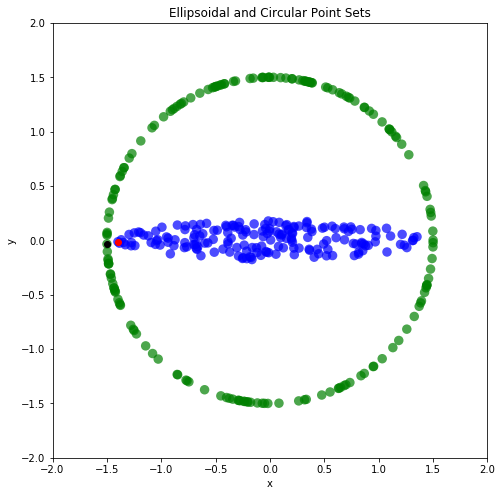

In [122]:
ellipse_index, circle_index = np.where(mahalanobis_distances == mahalanobis_distances.min())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_ellipse, y_ellipse, c='blue', alpha=0.7, edgecolor='none', s=90)
ax.set_title('Ellipsoidal and Circular Point Sets')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.scatter(x_circle, y_circle, c='green', alpha=0.7, edgecolor='none', s=90)
ax.scatter(x_ellipse[ellipse_index], y_ellipse[ellipse_index], c = 'red')
ax.scatter(x_circle[circle_index], y_circle[circle_index], c = 'k')
fig.set_size_inches(8,8)

## 2.3) scipy.spatial.distance.pdist

In [123]:
from scipy.spatial.distance import pdist

### 2.3.1) pdist basics -- very simple example

In [133]:
test_array = np.array([[0,0],
                       [0,1],
                       [0,2]])

The *condensed* distance matrix returned by `pdist` for the above `test_array` should have three values:

1. Distance between [0,0] and [0,1]
2. Distance between [0,0] and [0,2]
3. Distance between [0,1] and [0,2]

Let's try it:

In [134]:
condensed_matrix = pdist(test_array)
condensed_matrix

array([ 1.,  2.,  1.])

Although it may be relatively easy to track which distance value corresponds to which pair of points in this case, if `test_array` were much larger, working with a condensed distance matrix may become confusing.

This is where `scipy.spatial.distance.squareform` becomes useful:

In [135]:
from scipy.spatial.distance import squareform
redundant_matrix = squareform(condensed_matrix)
redundant_matrix

array([[ 0.,  1.,  2.],
       [ 1.,  0.,  1.],
       [ 2.,  1.,  0.]])

Even though `pdist` does not calculate the distance between a point and *itself*, `squareform` converts the condensed distance matrix to the familiar redundant form that would also be returned by `cdist` for the data set compared with *itself*:

In [136]:
cdist(test_array, test_array)

array([[ 0.,  1.,  2.],
       [ 1.,  0.,  1.],
       [ 2.,  1.,  0.]])

It is worth noting that `squareform` can perform the reverse conversion as well:

In [138]:
squareform(cdist(test_array, test_array)) # produce the same result as pdist by using squareform

array([ 1.,  2.,  1.])




| <font color='blue'>Development Note</font>| Type of Change | Pull Request # | `scipy` Implementation Version |
|----------------|------------|----------|
| `squareform` no longer converts all input data to `float64` | <font color='green'>Enhancement</font> | 6457 | <font color='purple'>0.19</font> |




### 2.3.2 pdist 'real-world' example

Imagine that you have experimental scientific data for the behavior of a protein (molecule) in the human body that causes a specific medical condition. Your suspicion is that this molecule becomes "compacted" / squished in the disease state. You want to know which two atoms are closest together in the normal vs. diseased state, to assess whether there really is evidence of compaction.

In [154]:
np.random.seed(387)
normal_coordinates = np.random.random((12000,3))
disease_coordinates = np.random.random((12000,3))

We could try a brute-force approach using `cdist` to compare a data set against itself:

In [173]:
normal_dist_matrix_cdist = cdist(normal_coordinates, normal_coordinates)
disease_dist_matrix_cdist = cdist(disease_coordinates, disease_coordinates)
print('normal min:', normal_dist_matrix_cdist.min())
print('disease min:', disease_dist_matrix_cdist.min())

normal min: 0.0
disease min: 0.0


We actually need to filter out the self-comparisons when using `cdist` in this manner. To do this, we effectively filter out the diagonal of the square distance matrix before calculating the minimum:

In [174]:
for name, cdist_array in zip(['normal', 'disease'], [normal_dist_matrix_cdist, disease_dist_matrix_cdist]):
    mask = np.ones(cdist_array.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    print(name, ':', cdist_array[mask].min())


normal : 0.00191693986339
disease : 0.00157908261241


But, as you may have guessed, the redundant square matrices produced by `cdist` can be quite large:

In [166]:
normal_dist_matrix_cdist.size, disease_dist_matrix_cdist.size

(144000000, 144000000)

It also just *feels* intuitively a bit strange to have to feed the same array of data to `cdist` twice, and this is a strong indicator that `pdist` may be a more efficient choice, especially for a large data set.

In [167]:
normal_dist_matrix_pdist = pdist(normal_coordinates)
disease_dist_matrix_pdist = pdist(disease_coordinates)
normal_dist_matrix_pdist.size, disease_dist_matrix_pdist.size

(71994000, 71994000)

In [178]:
normal_dist_matrix_cdist.size / normal_dist_matrix_pdist.size

2.000166680556713

The number of floating point numbers stored by the result of `pdist` is roughly half that stored by the return value of `cdist` in this case. This could make a really big difference when working with 'big data' sets.

Now, confirm that the results from the two approaches are simply transformations of the same data:

In [179]:
np.testing.assert_equal(squareform(disease_dist_matrix_cdist), disease_dist_matrix_pdist)

# 3) Distances between single numeric vectors

For computing the distances between two 1D arrays `scipy.spatial.distance` has many of the same functions as are available to the `metric` arguments of `pdist` and `cdist`. However, it is important to note that the `metric` for `pdist` and `cdist` should always be specified as the `string` type argument (i.e., "euclidean") to use the optimized C-level implementation instead of providing the built-in 1D vector distance function name (i.e., `scipy.spatial.distance.euclidean`).

Of course, in some cases one may actually wish to calculate the distance between two 1D vectors, for which the specific functions in scipy.spatial.distance are appropriate.

## 3.1) Calculate the Euclidean distance between two arrays

In [198]:
array_1 = np.random.random((3,))
array_2 = np.random.random((3,))
euclidean_dist = scipy.spatial.distance.euclidean(array_1, array_2)
euclidean_dist

0.3396883418445709

In [199]:
# but not appropriate for > 1D arrays
array_1 = np.random.random((2, 3))
array_2 = np.random.random((2, 3))
euclidean_dist = scipy.spatial.distance.euclidean(array_1, array_2)

ValueError: Input vector should be 1-D.

## 3.2) Calculate the cityblock distance between two arrays

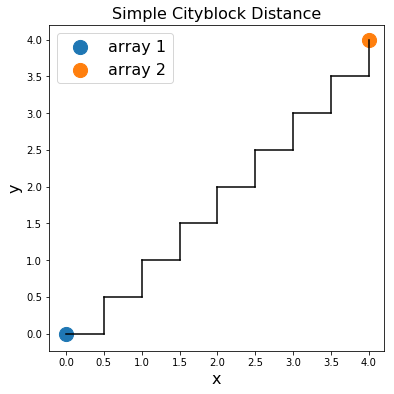

In [237]:
array_1 = np.zeros((2,))
array_2 = np.array([4, 4])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(array_1[0], array_1[1], s=200, label='array 1')
ax.scatter(array_2[0], array_2[1], s=200, label='array 2')
ax.legend(fontsize=16)
# add 'city blocks / steps' to plot
step_val = 0.5
current_pos = np.zeros((2,))
next_pos = np.zeros((2,))
x_val = 0
x_turn = 1
while x_val < 8:
    if x_turn:
        next_pos[0] += step_val
        x_turn = 0
    else:
        next_pos[1] += step_val
        x_turn = 1
        
    ax.plot([current_pos[0], next_pos[0]], [current_pos[1], next_pos[1]], c='k')
    current_pos[:] = next_pos[:]
    x_val += step_val

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title('Simple Cityblock Distance', fontsize=16)
fig.set_size_inches(6,6)

In [238]:
cityblock_dist = scipy.spatial.distance.cityblock(array_1, array_2)
cityblock_dist

8.0

Note that the City Block distance is equivalent to the sum of the x and y steps, and would be equivalent for one large block (single step).

## 3.3) Calculate the weighted Minkowski distance between two arrays

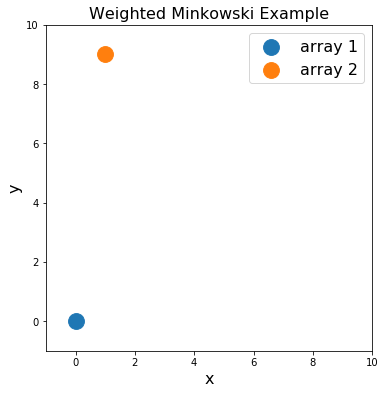

In [251]:
array_1 = np.zeros((2,))
array_2 = np.array([1,9])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(array_1[0], array_1[1], s=250, label='array 1')
ax.scatter(array_2[0], array_2[1], s=250, label='array 2')
ax.legend(fontsize=16)

ax.set_xlim(-1,10)
ax.set_ylim(-1,10)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_aspect('equal')
ax.set_title('Weighted Minkowski Example', fontsize=16)
fig.set_size_inches(6,6)

We could pick any p-norm for this calculation, but for conceptual simplicity let's stick with the Euclidean L2 norm. For the conventional Euclidean distance we would expect `d > 9` by simple visual inspection. 

However, given the small difference in `x` coordinate values, perhaps we can achieve `d < 9` with the appropriate weighting.

In [258]:
weight_vector = [1, 0]
weighted_euclidean_dist = scipy.spatial.distance.wminkowski(array_1, array_2, p=2, w=weight_vector)
weighted_euclidean_dist

1.0

In [259]:
weight_vector = [1, 0.1]
weighted_euclidean_dist = scipy.spatial.distance.wminkowski(array_1, array_2, p=2, w=weight_vector)
weighted_euclidean_dist

1.3453624047073711

In [266]:
weight_vector = [1, 1]
weighted_euclidean_dist = scipy.spatial.distance.wminkowski(array_1, array_2, p=2, w=weight_vector)
print('weighted_euclidean_dist with equal unit weights:', weighted_euclidean_dist)
assert weighted_euclidean_dist == scipy.spatial.distance.euclidean(array_1, array_2)

weighted_euclidean_dist with equal unit weights: 9.055385138137417


The shifting of the weighted distance matches nicely with intuition.

# 4) Distances between single boolean vectors

Once again, the specific 1D boolean distance functions in `scipy.spatial.distance` should only be used for comparison of two 1D vectors, while i.e., `pdist` with the metric `string` argument (i.e., "hamming") should be used for larger boolean comparisons.

## 4.1) Calculate the hamming distance between two 1D arrays

The *Reed-Solomon code* adds extra / redundant data bits to a data storage medium (i.e., CD, DVD, etc.) to assist with error correction. For example, error correction may be possible in the event of a minor scratch on the surface of a CD or if the reading device 'skips.' While the precise implementation details are beyond the scope of this example, if we think of these extra error-correcting bits as "code words," imagine a case where the encoder places a set of extra bits in the storage medium and the recovered equivalent word during decoding differs. We'd like a way to quantify the number of substitutions required to restore the original code word, which is an important metric in error correction.

In [285]:
original_code_word =  np.array([0, 1, 1, 0, 1, 1, 0, 0], dtype=np.bool)
recovered_code_word = np.array([1, 1, 0, 0, 1, 1, 0, 1], dtype=np.bool)

from scipy.spatial.distance import hamming
minimum_substitutions = hamming(original_code_word, recovered_code_word)
minimum_substitutions

0.375

Why isn't the Hamming distance an integer number corresponding to the number of positions that differ? Because we divide by the total number of "letters" (bits) in each "word" (byte). So, the scipy `hamming` function is really the **normalized** Hamming distance.

In [287]:
np.argwhere(original_code_word != recovered_code_word).size / original_code_word.size

0.375

Of course, the real-world implementation has more details and more bytes, so one might use i.e., `pdist` with the metric "hamming" argument for larger comparisons of arrays.

## 4.2) Calculate the Jaccard distance between two 1D arrays

Let's say we want to assess the ability of a computer program to identify a penguin in a real photograph based on a set of trial attempts to bound the animal. The photograph was taken by Jack Green with credit to the NSF as well.

![Emporor Penguin; Jack Green / NSF](emperor-penguin-alpha-construction-site-sign.jpg)

In [474]:
from scipy.spatial.distance import jaccard
from PIL import Image
im = Image.open('emperor-penguin-alpha-construction-site-sign.jpg')
im.size # pixel dimensions

(1524, 1128)

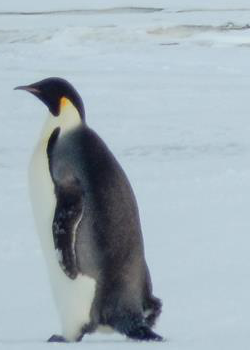

In [475]:
# define the reference / ground truth bounding box visually
x_start_ref = 350
x_end_ref = 550
y_start_ref = 600
y_end_ref = 900
box_actual = (x_start_ref, x_end_ref, y_start_ref, y_end_ref)
region = im.crop(box_actual)
region

In [464]:
# define ground truth reference matrix as a 1D boolean array of pixel matches to the original image
def generate_bool_matrix(original_image, x_start, x_end, y_start, y_end):
    matrix = np.zeros(original_image.size)
    matrix[x_start:x_end, y_start:y_end] = 1
    matrix = matrix.astype(np.bool, copy=False).ravel()
    return matrix

reference_matrix = generate_bool_matrix(im, x_start_ref, x_end_ref, y_start_ref, y_end_ref)
# sanity check on reference_matrix properties
reference_matrix, reference_matrix.shape, reference_matrix.sum(), ((x_end_ref - x_start_ref) * (y_end_ref - y_start_ref) )

(array([False, False, False, ..., False, False, False], dtype=bool),
 (1719072,),
 60000,
 60000)

Of course the numer of preserved pixels is the product of the pixel dimensions of the selection region.

Now, let's pretend we have some pixel bounding boxes selected by a variety of computer vision routines, and we want to identify the "best" approach.

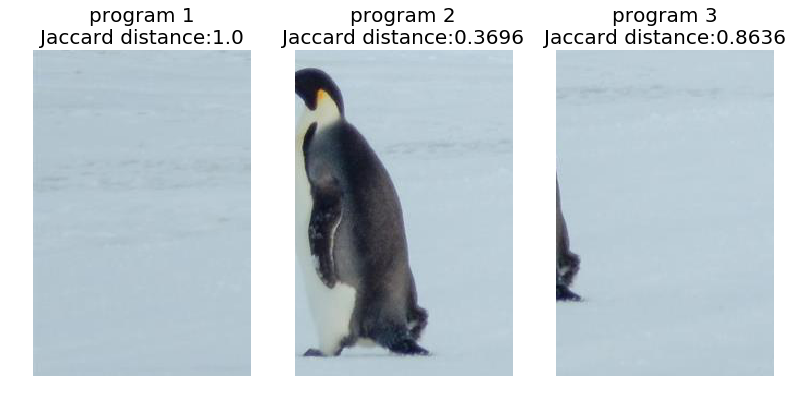

In [473]:
fig =  plt.figure()

# the pixel boundaries would typically come from some kind of computer vision routine
x_start_p1 = 0; x_start_p2 = 390; x_start_p3 = 490
x_end_p1 = 200; x_end_p2 = 590; x_end_p3 = 690
y_start_p1 = 600; y_start_p2 = 610; y_start_p3 = 660
y_end_p1 = 900; y_end_p2 = 910; y_end_p3 = 960

box_program_1 = (x_start_p1, y_start_p1, x_end_p1, y_end_p1)
box_program_2 = (x_start_p2, y_start_p2, x_end_p2, y_end_p2)
box_program_3 = (x_start_p3, y_start_p3, x_end_p3, y_end_p3)

plot_num = 1
for program_name, bounding_box in zip(['program 1', 'program 2', 'program 3'],
                                      [box_program_1, box_program_2, box_program_3]):
    ax = fig.add_subplot(1, 3, plot_num)
    current_region = im.crop(bounding_box)
    current_region_bool_matrix = generate_bool_matrix(im, bounding_box[0], bounding_box[2],
                                                      bounding_box[1], bounding_box[3])
    jaccard_dist = jaccard(current_region_bool_matrix, reference_matrix)
    ax.set_title('{program}\nJaccard distance:{dist}'.format(program=program_name,
                                                             dist=np.around(jaccard_dist, 4)),
                                                      fontsize=20)
    ax.imshow(current_region)
    ax.axis('off')
    plot_num += 1

fig.subplots_adjust(wspace=0.01)
fig.set_size_inches(14,6)

So, larger Jaccard distances are farther away from the ground truth match. We've just used a relatively simple 1D `scipy.spatial.distance` function to assess the output of computer vision routines. In pratice, one would normally use the **Jaccard index**, $J_I = 1 - J_D$, such that the best match has the highest value & values $ > 0.5 $ are typically considered decent matches.  